<a href="https://colab.research.google.com/github/jarifNmohsin/CNN/blob/main/CNN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [152]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [153]:
# Convert MNIST Image into a Tensor of 4-Dimensions (no. of images, Height, Width, Color Channels)
transform = transforms.ToTensor()

In [154]:
# Train Data
train_data = datasets.MNIST(root='/cnn_data', train=True, download=True, transform=transform)

In [155]:
# Test Data
test_data = datasets.MNIST(root='/cnn_data', train=False, download=True, transform=transform)

In [156]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [157]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [158]:
# Create a small batch size for images
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [159]:
# Define our CNN Model
# Describe convolutional layer (two)
conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 =  nn.Conv2d(6, 16, 3, 1)

In [160]:
# Grab one MNIST record/image
for i, (X_train, y_train) in enumerate(train_data):
  break

In [161]:
X_train.shape

torch.Size([1, 28, 28])

In [162]:
x = X_train.view(1, 1, 28, 28)

In [163]:
# Perform our first convulution
x = F.relu(conv1(x)) # Rectified Linear Unit for our activation function

In [164]:
# 1 single image, 6 is the filters we asked for, 26x26 (as we didn't put any padding)
x.shape

torch.Size([1, 6, 26, 26])

In [165]:
# pass thru the pooling layer
x = F.max_pool2d(x, 2, 2) # kernel of 2 and stride of 2

In [166]:
x.shape # 26 / 2 = 13

torch.Size([1, 6, 13, 13])

In [167]:
# Do our second convolutional layer
x = F.relu(conv2(x))

In [168]:
x.shape # Again we didn't put a padding so we lose 2 pixels around the outside of the image

torch.Size([1, 16, 11, 11])

In [169]:
# Pooling layer
x = F.max_pool2d(x, 2, 2)

In [170]:
x.shape # 11 / 2 = 5.5 but we have it round down, because we can't invent data to round up

torch.Size([1, 16, 5, 5])

In [171]:
((28-2) / 2 - 2) / 2

5.5

In [172]:
# Model Class
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 6, 3, 1)
    self.conv2 = nn.Conv2d(6, 16, 3, 1)
    # Fully connected layer
    self.fc1 = nn.Linear(5*5*16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X, 2, 2)
    # Second pass
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X, 2, 2)

    # Review to flatten it out
    X = X.view(-1, 16*5*5) # -1 because we can vary the batch size

    # Fully connected Layers
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X) # No relu as it is the last layer
    return F.log_softmax(X, dim=1)


In [173]:
# Create an instance of our Model
torch.manual_seed(41)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [174]:
# Loss function optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [175]:
import time
start_time = time.time()

# Create variables to track things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []



# For Loop of Epochs
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0


  # Train
  for b,(X_train, y_train) in enumerate(train_loader):
    b+=1 # start our batches at 1
    y_pred = model(X_train) # get pred vals from training set. Not flattened but 2D
    loss = criterion(y_pred, y_train) # how off are we? Compare preds to the correct ans in y_train

    predicted = torch.max(y_pred.data, 1)[1] # add up the numbers of correct preds. Indexed off the first point
    batch_corr = (predicted == y_train).sum() # how many correct we have from this batch. True=1, False=0
    trn_corr += batch_corr # keep track of corrects

    # Update our parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print out some results
    if b%600 == 0:
      print(f'Epoch: {i} Batch: {b} Loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)


  # Test
  with torch.no_grad(): # NO gradient so we don't update our weights and biases with test data
    for b,(X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1] # Adding up correct predictions
      tst_corr += (predicted == y_test).sum() # T=1 F=0 and sum away\


  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)


current_time = time.time()
total = current_time - start_time
print(f'Training took: {total/60} minutes!')



Epoch: 0 Batch: 600 Loss: 0.1623610556125641
Epoch: 0 Batch: 1200 Loss: 0.1502392590045929
Epoch: 0 Batch: 1800 Loss: 0.4744560718536377
Epoch: 0 Batch: 2400 Loss: 0.14238706231117249
Epoch: 0 Batch: 3000 Loss: 0.007758188061416149
Epoch: 0 Batch: 3600 Loss: 0.3836284875869751
Epoch: 0 Batch: 4200 Loss: 0.0038223876617848873
Epoch: 0 Batch: 4800 Loss: 0.0021286322735249996
Epoch: 0 Batch: 5400 Loss: 0.0569545142352581
Epoch: 0 Batch: 6000 Loss: 0.00038789428072050214
Epoch: 1 Batch: 600 Loss: 0.005851339548826218
Epoch: 1 Batch: 1200 Loss: 0.3855525553226471
Epoch: 1 Batch: 1800 Loss: 0.004819948226213455
Epoch: 1 Batch: 2400 Loss: 0.003216963727027178
Epoch: 1 Batch: 3000 Loss: 0.0332382395863533
Epoch: 1 Batch: 3600 Loss: 0.5372857451438904
Epoch: 1 Batch: 4200 Loss: 0.04561494290828705
Epoch: 1 Batch: 4800 Loss: 0.0007510822033509612
Epoch: 1 Batch: 5400 Loss: 0.0001173773780465126
Epoch: 1 Batch: 6000 Loss: 0.14201366901397705
Epoch: 2 Batch: 600 Loss: 0.023733172565698624
Epoch: 2

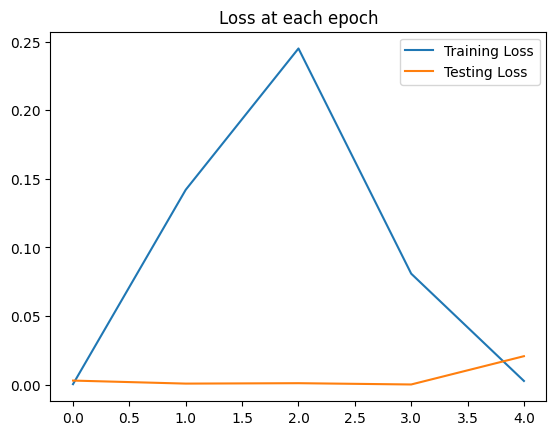

In [176]:
# Graph the loss at each epoch
train_losses = [t1.item() for t1 in train_losses]
test_losses = [t1.item() for t1 in test_losses]
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.title('Loss at each epoch')
plt.legend()

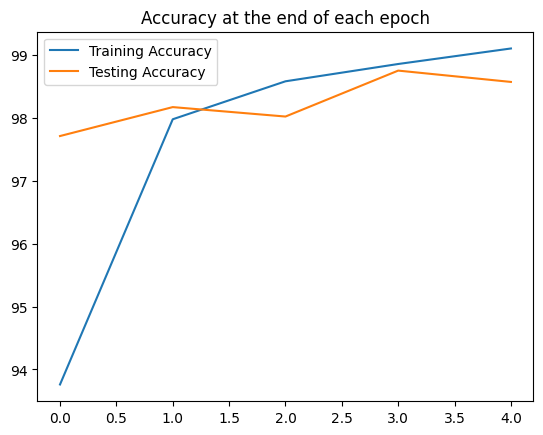

In [177]:
# graph the accuracy at the end of each epoch
plt.plot([t/600 for t in train_correct], label='Training Accuracy')
plt.plot([t/100 for t in test_correct], label='Testing Accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend()

In [180]:
accuracy = tst_corr.item() / len(test_data) * 100
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 98.57%


In [181]:
# Grab an image
test_data[4143] # Tensor with an image in it....at the end it shows labels

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [182]:
# Grab just the data
test_data[4143][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [183]:
# Reshape it
test_data[4143][0].reshape(28, 28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

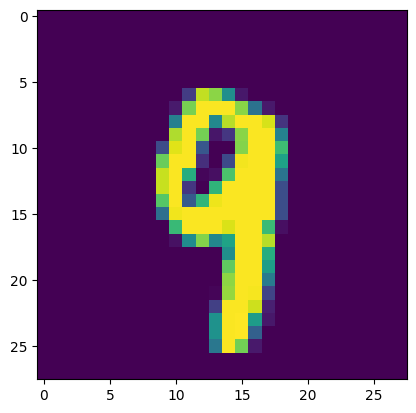

In [187]:
# Show the image
plt.imshow(test_data[4143][0].reshape(28, 28))

In [188]:
# pass the image thru the model
model.eval()
with torch.no_grad():
  new_pred = model(test_data[4143][0].view(1, 1, 28, 28)) # batch size of 1, 1 color channel, 28x28 image

In [189]:
# Check the new pred...get probabilities from 0 to 9
new_pred

tensor([[-2.1693e+01, -1.8584e+01, -2.1709e+01, -1.5842e+01, -8.6330e+00,
         -1.8415e+01, -3.1769e+01, -1.2734e+01, -1.3396e+01, -1.8273e-04]])

In [190]:
new_pred.argmax()

tensor(9)